## Flow and Speed Prediction

In [299]:
import numpy as np
import networkx as nx
from scipy.sparse import linalg

def flow_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]

    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
    
    return pred_flows

In [290]:
# Author: Vlad Niculae 
#         Lars Buitinck 
# Author: Chih-Jen Lin, National Taiwan University (original projected gradient
#     NMF implementation)
# Author: Anthony Di Franco (original Python and NumPy port)
# License: BSD 3 clause

from sklearn.utils.extmath import safe_sparse_dot
from scipy.sparse import csr_matrix, issparse
from scipy.optimize import fmin_l_bfgs_b

def safe_fro(X, squared=False):
    if issparse(X):
        nrm = np.sum(X.data ** 2)
    else:
        if hasattr(X, 'A'):
            X = X.A
        nrm = np.sum(X ** 2)
    return nrm if squared else np.sqrt(nrm)
     

# Authors: Mathieu Blondel, Vlad Niculae
def nls_lbfgs_b(X, Y, W_init=None, l1_reg=0, l2_reg=0, max_iter=5000, tol=1e-3, callback=None):
    """Non-negative least squares solver using L-BFGS-B.
        
    Solves for W in
    min 0.5 ||Y - XW||^2_F + + l1_reg * sum(W) + 0.5 * l2_reg * ||W||^2_F
    
    """
    n_samples, n_features = X.shape
    n_targets = Y.shape[1]
    G = safe_sparse_dot(X.T, X)
    Xy = safe_sparse_dot(X.T, Y)

    def f(w, *args):
        W = w.reshape((n_features, n_targets))
        diff = (safe_sparse_dot(X, W) - Y)
        diff = diff.A if hasattr(diff, 'A') else diff
        res = 0.5 * np.sum(diff ** 2)
        if l2_reg:
            res += 0.5 * l2_reg * np.sum(W ** 2)
        if l1_reg:
            res += l1_reg * np.sum(W)
        return res

    def fprime(w, *args):
        W = w.reshape((n_features, n_targets))
        #grad = (np.dot(G, W) - Xy).ravel()
        grad = (safe_sparse_dot(G, W) - Xy).ravel()
        if l2_reg:
            grad += l2_reg * w
        if l1_reg:
            grad += l1_reg
        return grad

    if W_init is None:
        W = np.zeros((n_features * n_targets,), dtype=np.float64)
    else:
        W = W_init.ravel().copy()
    W, residual, d = fmin_l_bfgs_b(
                f, x0=W, fprime=fprime, pgtol=tol,
                bounds=[(0, None)] * n_features * n_targets,
                maxiter=max_iter,
                callback=callback)
    
    # testing reveals that sometimes, very small negative values occur
    W[W < 0] = 0
    
    if l1_reg:
        residual -= l1_reg * np.sum(W)
    if l2_reg:
        residual -= 0.5 * l2_reg * np.sum(W ** 2)
    residual = np.sqrt(2 * residual)
    if d['warnflag'] > 0:
        print("L-BFGS-B failed to converge")
    
    return W.reshape((n_features, n_targets)), residual

In [291]:
import scipy 

def flow_prediction_nls(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction with non-negative least squares
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]
    
    #X_wide = np.random.uniform(low=0, high=1, size=(50, 100))
    #Y_wide = np.random.uniform(low=0, high=1, size=(50, 1))
    #W, resid = nls_projgrad(X_wide, Y_wide)
    
    #res = linalg.lsmr(A, b, damp=lamb)
    A = A.tocsr()
    #b = scipy.sparse.csr_matrix(b.reshape(b.shape[0], 1))
    b = scipy.sparse.csr_matrix(b.reshape(b.shape[0],1))
    
    res = nls_lbfgs_b(A, b, l2_reg=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = np.array([labelled_flows[e]])
        else:
            pred_flows[e] = x[index[e]]
    
            
    return pred_flows

In [307]:
def speed_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    line_G = nx.line_graph(G)
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]
    
    pred_flows = {}

    for e in G.edges:
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
            
    return pred_flows

## Sensor Selection Algorithm

In [293]:
def mse(pred_labels, labeled_edges):
    return sum([(v - pred_labels[k]) ** 2 for k, v in labeled_edges.items()]) / len(labeled_edges)     

In [371]:
from tqdm.notebook import tqdm
from multiprocess import Pool 
import heapq

def choose_sensors(G, labeled_edges, predict, evaluate, k=None, lazy=True, cores=4):
    """
    Choose `k` sensors greedily to optimize the prediction given by `predict` for ground truth `labels`
    based on loss function `evaluate` (lower loss is better). 
    
    Parameters:
        -- G: networkx graph
        -- labeled_edges: dict {edge : value}
        -- predict: function taking G, labeled_edges -> prediction
        -- evaluate: prediction, true_values -> loss
    """
    if k == None:
        k = int(G.number_of_edges() / 50)
    
    sensors = []
        
    # Find value of adding each edge not in the set
    current = evaluate(predict(G, {}), labeled_edges)

    with Pool(cores) as pool:
        deltas = pool.map(lambda e: (evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges) - current, e), 
                          labeled_edges)

    heapq.heapify(deltas)
    print("initial len(deltas):", len(deltas))
    
    # Greedily select sensors
    if lazy:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
#             print("iteration {}, current {}".format(i, current))

            # Current top 
            _, s = heapq.heappop(deltas)
            delta = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}), 
                             labeled_edges) - current
            
            if len(deltas) == 0:
                sensors.append(s)
                continue

            # Next top
            delta_next, s_next = heapq.heappop(deltas)
            delta_next -= current
            
            print("sensor {} delta {}".format(s, delta))
            print("next top sensor {} delta {}".format(s_next, delta_next))
#             print("deltas: {}".format(deltas))
            
            if delta <= delta_next:
                heapq.heappush(deltas, (delta_next, s_next))
                
            # If the change drops it below the next best, recalculate the next best and continue
            while delta > delta_next:
                print("sensor {} delta {}".format(s, delta))
                print("next top sensor {} delta {}".format(s_next, delta_next))
                delta_next = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s_next : labeled_edges[s_next]}), 
                             labeled_edges) - current
                if delta_next < delta:
                    heapq.heappush(deltas, (delta, s))
                    delta, s = delta_next, s_next
                    print("next > delta, len(deltas)", len(deltas))
                else:
                    heapq.heappush(deltas, (delta_next, s_next))
                    print("delta > next, len(deltas):", len(deltas))
                    delta_next, s_next = heapq.heappop(deltas)
                    
                    if delta <= delta_next:
                        heapq.heappush(deltas, (delta_next, s_next))
                        break
                
            print("iteration", i, "len(deltas):", len(deltas))
            print("selecting sensor {} delta {}, next sensor {} has delta {}".format(s, delta, s_next, delta_next))
            sensors.append(s)
            print()
    else:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
            # print("iteration {}, current {}".format(i, current))
            opt, opt_cost = None, float("inf")
            for s in G.edges():
                if s not in sensors:
                    cost = evaluate(predict(G, {e : labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}),
                                   labeled_edges)
                    # print("sensor {} cost {} opt {}".format(s, cost, opt_cost))
                    if cost < opt_cost:
                        opt, opt_cost = s, cost
            sensors.append(opt)
        
    return sensors

In [7]:
"""
Randomly select k edges from the graph.
"""
def choose_sensors_random(G, k=None, dummy=None):
    if k == None:
        k = int(G.number_of_edges() / 50)
        
    H = G.__class__()
    H.add_nodes_from(G)
    H.add_edges_from(G.edges)
    
    if dummy in H.nodes:
        H.remove_node(dummy)
        
    choice = np.random.choice(H.number_of_edges(), k, replace=False)
    selected = []
    for i, e in enumerate(H.edges):
        if i in choice:
            selected.append(e)
        
    return selected

### Testing

Should choose one node from each cluster

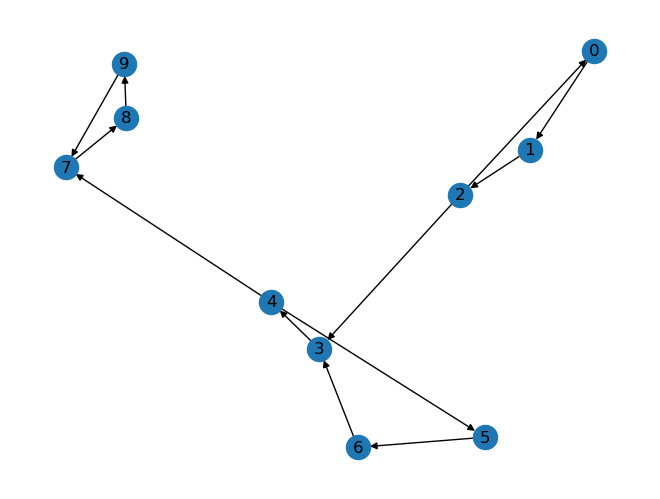

In [334]:
J = nx.DiGraph()

J.add_edge(0,1)
J.add_edge(1,2)
J.add_edge(2,0)
J.add_edge(2,3)
J.add_edge(3,4)
J.add_edge(4,5)
J.add_edge(6,3)
J.add_edge(5,6)
J.add_edge(4,7)
J.add_edge(7,8)
J.add_edge(8,9)
J.add_edge(9,7)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(2,0)] = 10.
flows[(2,3)] = 0.
flows[(3,4)] = 20.
flows[(4,5)] = 20.
flows[(6,3)] = 20
#flows[(6,4)] = 10.
flows[(5,6)] = 20.
flows[(4,7)] = 0
flows[(7,8)] = 30
flows[(8,9)] = 30
flows[(9,7)] = 30

np.random.seed(540)
nx.draw(J, with_labels=True)

In [358]:
opt = choose_sensors(J, flows, flow_prediction, mse, 3)
opt

initial len(deltas): 12


  0%|          | 0/3 [00:00<?, ?it/s]

iteration 0 len(deltas): 11
iteration 1 len(deltas): 10
iteration 2 len(deltas): 9


[(9, 7), (3, 4), (0, 1)]

In [336]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt}))

2.082821407672434e-21

In [337]:
opt_lazy = choose_sensors(J, flows, flow_prediction, mse, lazy=True, k=3)
opt_lazy

  0%|          | 0/3 [00:00<?, ?it/s]

[(9, 7), (3, 4), (0, 1)]

In [338]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt_lazy[:3]}))

2.082821407672434e-21

In [359]:
speeds = synthetic_speeds(J, 2)
speeds

2444511.851256318


{(0, 1): -31.844024215201035,
 (1, 2): 288.6751345948124,
 (2, 0): -411.34614729257754,
 (2, 3): 281.672843078511,
 (3, 4): 207.41984227762165,
 (4, 5): 211.54249846408143,
 (4, 7): 189.8528863386806,
 (5, 6): -188.9822365046119,
 (6, 3): 4.156005597928834e-13,
 (7, 8): 691.1765413460597,
 (8, 9): -155.19315485798705,
 (9, 7): 6.415425138655647}

In [360]:
opt = choose_sensors(J, speeds, speed_prediction, mse, 3)
opt

initial len(deltas): 12


  0%|          | 0/3 [00:00<?, ?it/s]

iteration 0 len(deltas): 11
iteration 1 len(deltas): 10
iteration 2 len(deltas): 9


[(2, 0), (0, 1), (6, 3)]

In [345]:
mse(speeds, speed_prediction(J, {s : speeds[s] for s in opt}))

80073.31456764277

## Testing - Small Network

In [295]:
import pandas as pd

def get_labels_from_df(df, from_idx, to_idx, label_idx):
    labeled_edges = {}
    for e in df.itertuples():
        labeled_edges[(e[from_idx], e[to_idx])] = e[label_idx]
    return labeled_edges

In [14]:
city = "small"

edgelist = pd.read_csv("out/" + city + ".results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


In [15]:
G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)

In [16]:
from copy import deepcopy

G_dummy = deepcopy(G)

dummy = "dummy"

for v in deepcopy(G_dummy.nodes()):
    if G_dummy.out_degree(v) == 0:
        G_dummy.add_edge(v, dummy)
    if G_dummy.in_degree(v) == 0:
        G_dummy.add_edge(dummy, v)

In [17]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


In [284]:
import matplotlib as mpl
import matplotlib.pyplot as plt

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}

In [ ]:
# Add a plot of running time for lazy vs regular for various graphs
# Choose maybe 10% of nodes (more takes too long without lazy evaluation)

## Benchmarks

### TODO

Get benchmarks from active learning paper

## Error Metrics

In [ ]:
def geh(pred, actual):
    if pred == actual == 0:
        return np.array([0])
    return np.sqrt((2 * (pred - actual) ** 2) / (pred + actual))

In [ ]:
def mape(pred_labels, labeled_edges):
    return 100 * sum([abs((v - pred_labels[k]) / v) for k, v in labeled_edges.items()]) / len(labeled_edges) 

# Some Results

## Synthetic Flows

In [21]:
def synthetic_flows(G, b=0.02, epsilon=0.1):
    B = nx.incidence_matrix(G, oriented=True)
    u, s, vh = scipy.linalg.svd(B.todense())
    ss = np.zeros(vh.shape[0])
    ss[:s.shape[0]] = s
    
    vec = np.zeros(vh.shape[0])

    for i in range(vh.shape[0]):
        vec = vec + b / (ss[i]+epsilon) * vh[i]
        
    flows = {}
    
    i = 0
    for e in G.edges():
        flows[e] = vec[i] * 1000
        i = i + 1
        
    return flows

In [22]:
def vect2dict(G, x):
    labels = {}
    for i, e in enumerate(G.edges()):
        labels[e] = x[i]
    return labels

In [348]:
def synthetic_speeds(G, i, b=1000):
    eigs = np.linalg.eig(nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=G.edges()).toarray())
    print((b * eigs[1][i]).transpose() @ nx.laplacian_matrix(nx.line_graph(G).to_undirected(), nodelist=G.edges()) @ (b * eigs[1][i]))
    return vect2dict(G, b * eigs[1][i])

In [232]:
# Generate the flows with a dummy node to handle sources/sinks
labeled_synthetic_flows = synthetic_flows(G_dummy)

# Mark all edges to/from the dummy as unlabeled
for e, f in deepcopy(labeled_synthetic_flows).items():
    if dummy in e:
        del labeled_synthetic_flows[e]

In [233]:
opt_sensors = choose_sensors(G_dummy, labeled_synthetic_flows, flow_prediction, mse, lazy=True, k=int(len(G.edges()) / 2), cores=10)

  0%|          | 0/610 [00:00<?, ?it/s]

In [280]:
random_sensors = choose_sensors_random(G_dummy, k=int(len(G.edges()) / 2), dummy=dummy)

samples = 100
errs = {}
random_errs = {}

for i in tqdm(range(samples)):
    j = int(len(random_sensors) / samples) * i
    
    preds = flow_prediction(G_dummy, {s: labeled_synthetic_flows[s] for s in opt_sensors[:j]})
    errs[j] = mse(preds, labeled_synthetic_flows)
    
    random_preds = flow_prediction(G, {s: labeled_synthetic_flows[s] for s in random_sensors[:j]})
    random_errs[j] = mse(random_preds, labeled_synthetic_flows)

  0%|          | 0/100 [00:00<?, ?it/s]

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

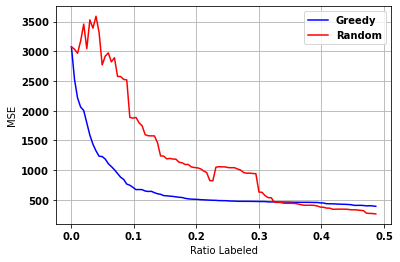

In [285]:
fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 10})

ax.plot([k / len(G.edges()) for k in errs.keys()], errs.values(), "b", label="Greedy")
ax.plot([k / len(G.edges()) for k in random_errs.keys()], random_errs.values(), "r", label="Random")
ax.legend()
plt.xlabel("Ratio Labeled")
plt.ylabel("MSE")
plt.grid("on")
plt.savefig("results_traffic.pdf", bbox_inches="tight")
plt.show()

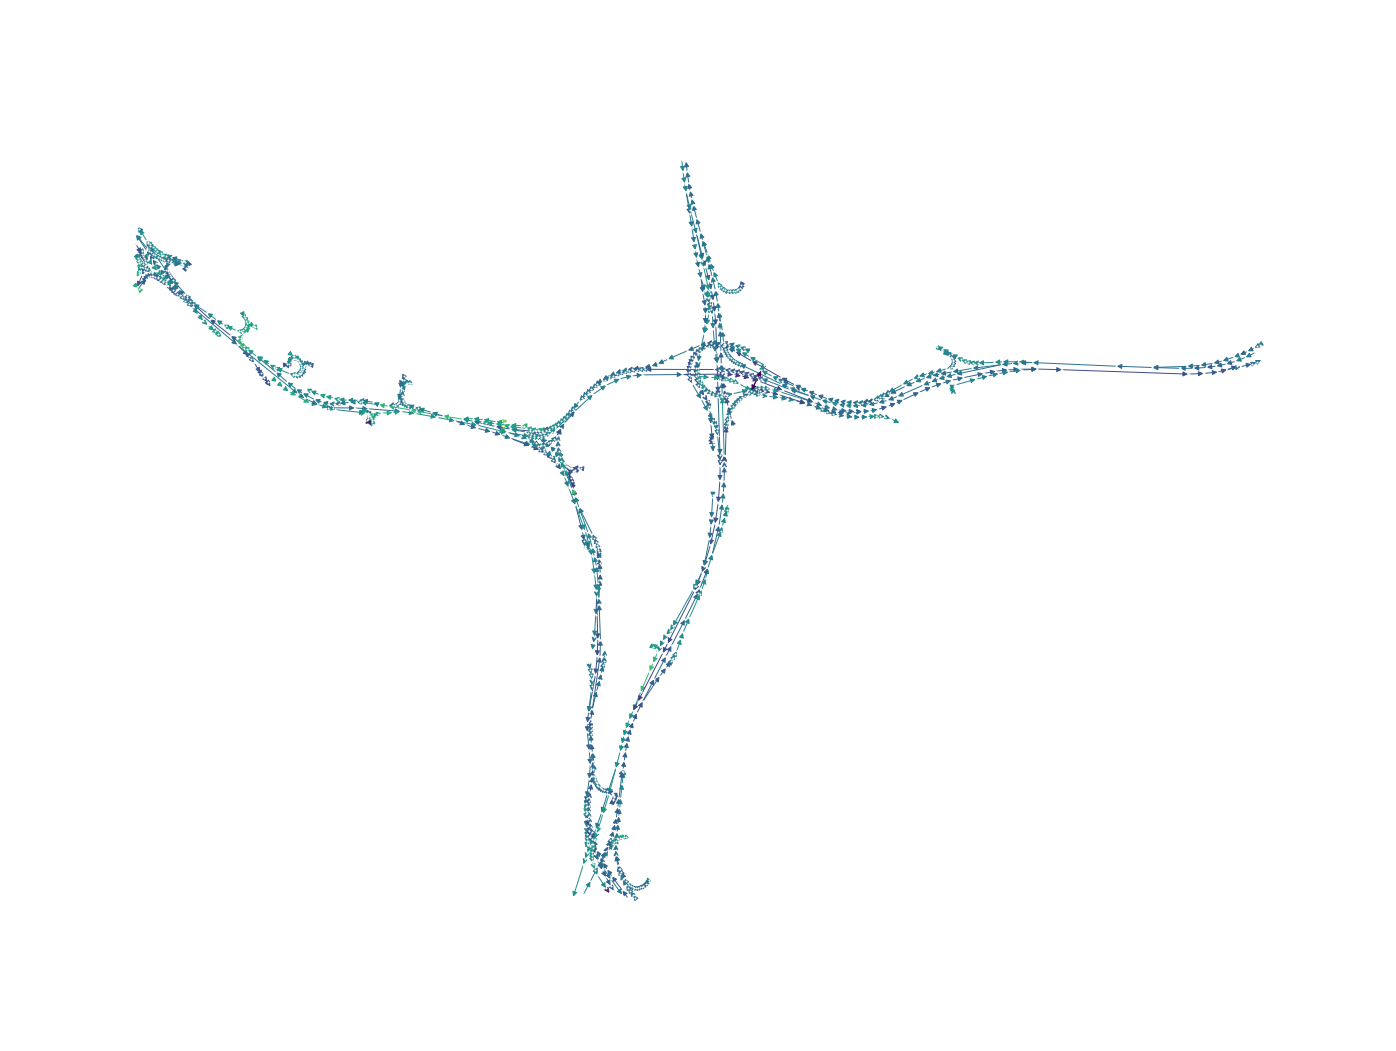

In [249]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])
edge_colors = [labeled_synthetic_flows[e] for e in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.savefig("ground_truth_flows.pdf", bbox_inches="tight")
plt.show()

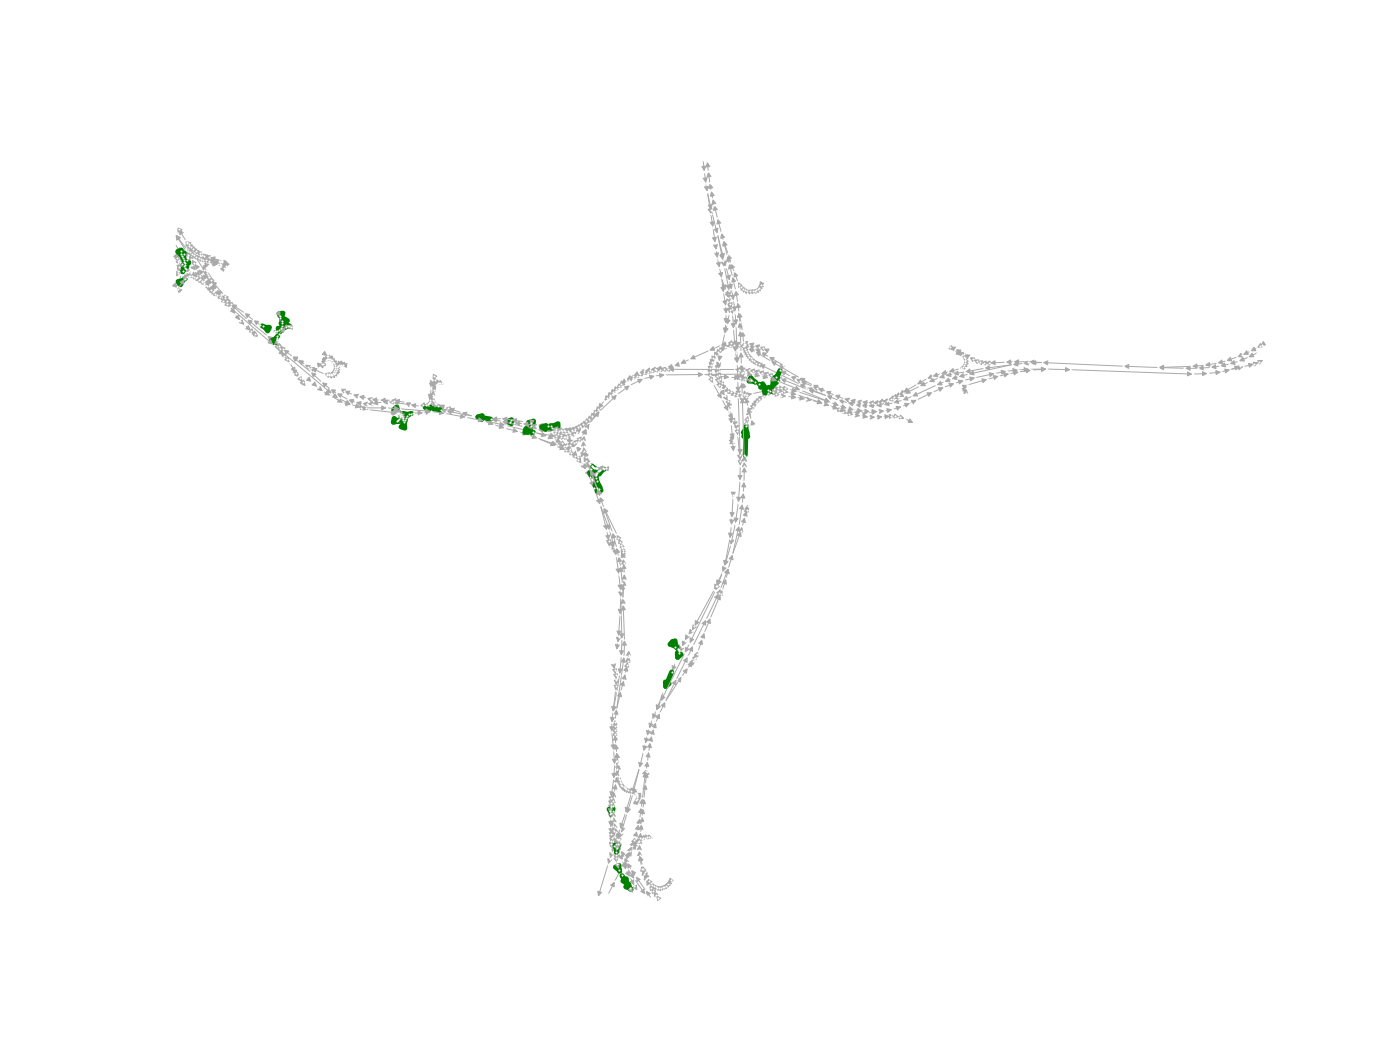

In [271]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])
edge_colors = ["green" if (u, v) in opt_sensors[:50] else "darkgray" for u, v in G.edges()]
width = [5 if e in opt_sensors[:50] else 1 for e in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors, width=width)
plt.savefig("optimal_sensors_flows.pdf")
plt.show()

In [ ]:
preds = flow_prediction_nls()
plt.plot(zip(dict2vec(labeled_flows), dict2vec(preds)))

In [190]:
labeled_speeds = synthetic_speeds(G, 2) # use second eigenvector of Laplacian

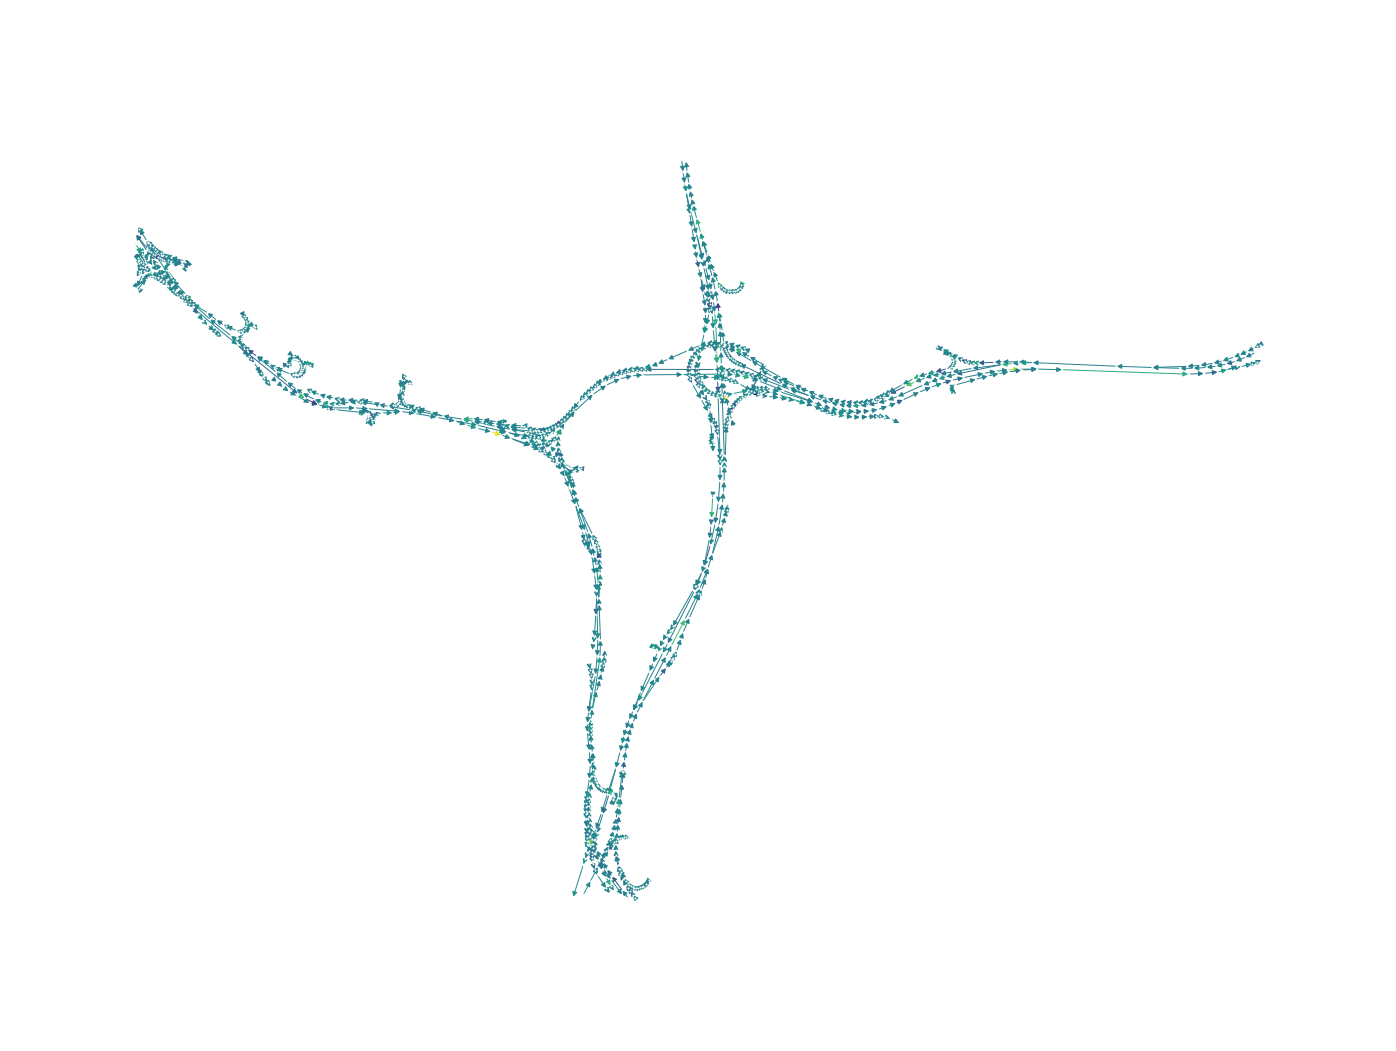

In [193]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])
edge_color = [labeled_speeds[e] for e in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_color)
plt.show()

In [ ]:
def dict2vect(G, labels):
    x = np.zeros(G.number_of_edges())
    for i, e in enumerate(G.edges()):
        try:
            x[i] = labels[e]
    return x

In [195]:
opt_speed_sensors = choose_sensors(G, labeled_speeds, speed_prediction, mse, lazy=True, k=int(len(G.edges()) / 2), cores=10)

  0%|          | 0/610 [00:00<?, ?it/s]

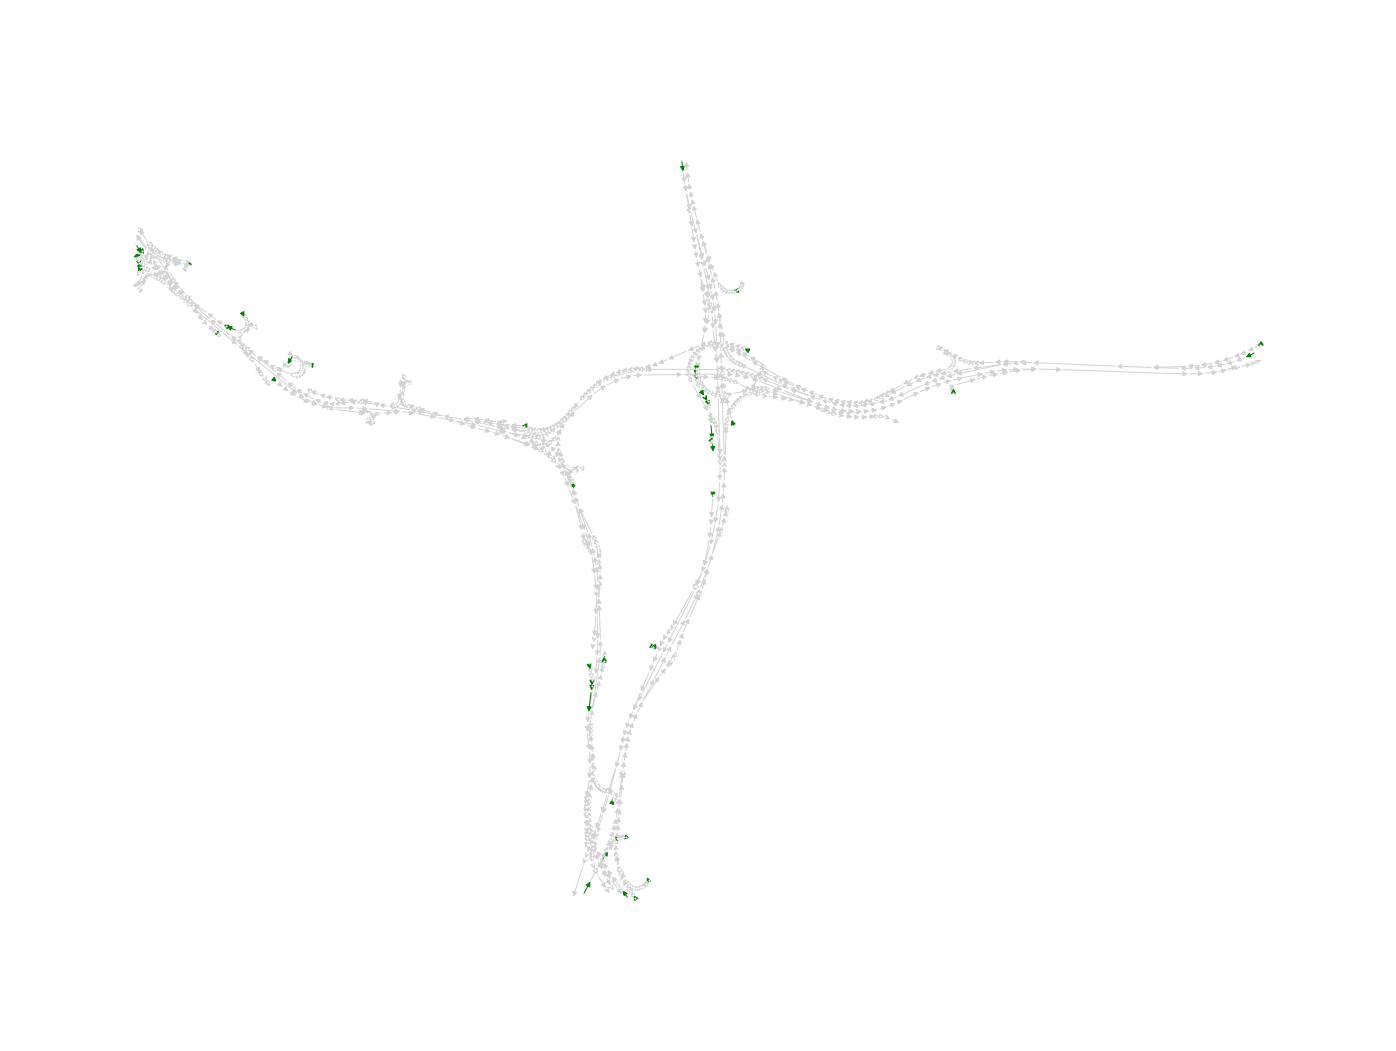

In [203]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])
edge_color = ["green" if (u, v) in opt_speed_sensors[:50] else "lightgray" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_color)
plt.savefig("opt_speed_sensors.pdf")
plt.show()

In [196]:
preds = speed_prediction(G, {s: labeled_speeds[s] for s in opt_speed_sensors[:1]})
mse(preds, labeled_speeds)

817.4946896259487

In [198]:
random_sensors = choose_sensors_random(G, int(G.number_of_edges() / 2))

In [199]:
random_errs = {}
errs = {}
samples = 100

for i in tqdm(range(samples)):
    j = int(len(random_sensors) / samples) * i
    
    preds = speed_prediction(G, {s: labeled_speeds[s] for s in opt_speed_sensors[:j]})
    errs[j] = mse(preds, labeled_speeds)
    
    random_preds = speed_prediction(G, {s: labeled_speeds[s] for s in random_sensors[:j]})
    random_errs[j] = mse(random_preds, labeled_speeds)

  0%|          | 0/100 [00:00<?, ?it/s]

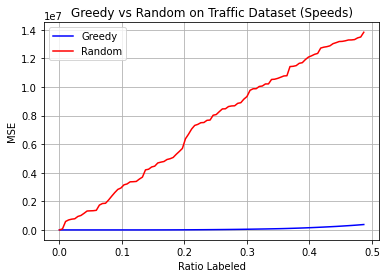

In [200]:
fig, ax = plt.subplots()

ax.plot([k / len(G.edges()) for k in errs.keys()], errs.values(), "b", label="Greedy")
ax.plot([k / len(G.edges()) for k in errs.keys()], random_errs.values(), "r", label="Random")
ax.legend()
plt.xlabel("Ratio Labeled")
plt.ylabel("MSE")
plt.grid("on")
plt.show()

## Demonstrating Speedups

In [ ]:
import time

speedups = {}

for i in range(500, 2000, 500):
    RG = nx.gnp_random_graph(i, 0.001, directed=True)
    
    # Generate flows
    RG_dummy = deepcopy(RG)
    for v in deepcopy(G_dummy.nodes()):
        if G_dummy.out_degree(v) == 0:
            G_dummy.add_edge(v, dummy)
        if G_dummy.in_degree(v) == 0:
            G_dummy.add_edge(dummy, v)
            
    flows = synthetic_flows(G_dummy)
    
    # Mark all edges to/from the dummy as unlabeled
    for e, f in deepcopy(labeled_synthetic_flows).items():
        if dummy in e:
            del labeled_synthetic_flows[e]

    t0 = time.time()
    choose_sensors(G_dummy, flows, flow_prediction_nls, mse, k=int(i / 100), lazy=True, cores=10)
    lazy_time = time.time() - t0
    
    t0 = time.time()
    choose_sensors(G_dummy, flows, flow_prediction_nls, mse, k=int(i / 100), lazy=False, cores=10)
    slow_time = time.time() - t0
    
    speedups[i] = (lazy_time, slow_time)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [273]:
speedups

{500: (24.99667239189148, 1312.311910867691),
 1000: (29.964611053466797, 2972.4408638477325),
 1500: (23.427258253097534, 4453.126877307892)}

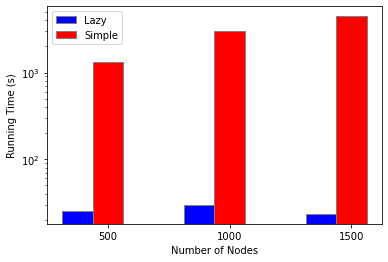

In [276]:
lazy, iterative = list(zip(*speedups.values()))

barWidth = 0.25
fig, ax = plt.subplots()
 
b1 = np.arange(len(lazy))
b2 = [x + barWidth for x in b1]
 
# Make the plot
plt.bar(b1, lazy, color ='b', width = barWidth,
        edgecolor ='grey', label ='Lazy')
plt.bar(b2, iterative, color ='r', width = barWidth,
        edgecolor ='grey', label ='Simple')
 
# Adding Xticks
plt.xlabel('Number of Nodes')
plt.ylabel('Running Time (s)')
plt.xticks([r + barWidth for r in range(len(lazy))],
        list(range(500, 2000, 500)))
plt.legend()
plt.yscale("log")
plt.savefig("running_time.pdf", bbox_inches="tight")
plt.show()

## Some Real Graphs

### Power Flows

In [238]:
power_edgelist = pd.read_csv("data/power_net.csv", header=None, names=["source", "target"])
power_edgelist.head()

,source,target
0,DE0 143,DE0 143-x
1,DE0 143,DE0 8
2,FR0 18,FR0 29
3,FR0 18,FR0 18-x
4,FR0 18,FR0 98


In [239]:
power_graph = nx.from_pandas_edgelist(power_edgelist, source="source", target="target", create_using=nx.DiGraph)

In [240]:
import pickle

with open('data/flows_power.pkl', 'rb') as f:
    power_flows = pickle.load(f)

In [241]:
labeled_power_flows = {}
for e in power_graph.edges():
    u, v = e
    if e in power_flows:
        labeled_power_flows[e] = power_flows[e]
    else: 
        labeled_power_flows[e] = power_flows[(v, u)]

In [242]:
for e in deepcopy(power_graph.edges()):
    if power_graph.out_degree(e) == 0:
        power_graph.add_edge(e, dummy)
    if power_graph.in_degree(e) == 0:
        power_graph.add_edge(dummy, e)

In [243]:
opt_power_sensors = choose_sensors(power_graph, labeled_power_flows, flow_prediction, mse, lazy=True, 
                             k=int(len(labeled_power_flows) / 2))

  0%|          | 0/1364 [00:00<?, ?it/s]

In [245]:
mse(flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in opt_power_sensors}), labeled_power_flows)

array([262026.9536325])

In [246]:
random_sensors = choose_sensors_random(power_graph, k=int(len(labeled_power_flows) / 2))
random_errs = {}

errs = {}
samples = 50

for i in tqdm(range(samples)):
    j = int(len(random_sensors) / samples) * i
    
    preds = flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in opt_power_sensors[:j]})
    errs[j] = mse(preds, labeled_power_flows)
    
    random_preds = flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in random_sensors[:j]})
    random_errs[j] = mse(random_preds, labeled_power_flows)

  0%|          | 0/50 [00:00<?, ?it/s]

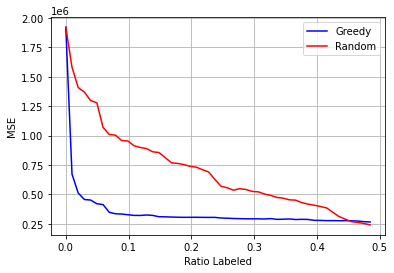

In [247]:
fig, ax = plt.subplots()

ax.plot([k / len(power_graph.edges()) for k in errs.keys()], errs.values(), "b", label="Greedy")
ax.plot([k / len(power_graph.edges()) for k in random_errs.keys()], random_errs.values(), "r", label="Random")
ax.legend()
plt.xlabel("Ratio Labeled")
plt.ylabel("MSE")
plt.grid("on")
plt.savefig("power_results.pdf", bbox_inches="tight")
plt.show()
# plt.plot(range(len(errs.values())), errs.values(), range(len(random_errs.values())), random_errs.values(), 
#          xlabel="Number of Sensors", ylabel="MSE")

In [79]:
def dict2vector(G, labels):
    x = np.zeros(len(G.edges))
    for i, e in enumerate(G.edges()):
        x[i] = labels[e]
    return x

In [84]:
corrs = {}
rand_corrs = {}

for i in tqdm(range(samples)):
    j = int(len(random_sensors) / samples) * i
    
    preds = flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in opt_sensors[:j]})
    corrs[j] = np.corrcoef(dict2vector(power_graph, preds), dict2vector(power_graph, labeled_power_flows))[0][1]
    
    random_preds = flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in random_sensors[:j]})
    rand_corrs[j] = np.corrcoef(dict2vector(power_graph, random_preds), dict2vector(power_graph, labeled_power_flows))[0][1]

  0%|          | 0/50 [00:00<?, ?it/s]

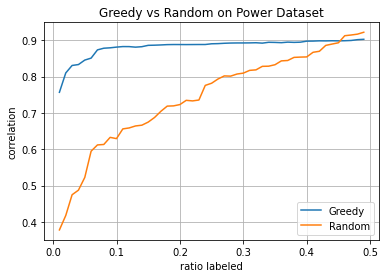

In [86]:
fig, ax = plt.subplots()

ratio = len(opt_sensors) / len(power_graph.edges())

ax.plot([i / (samples) * ratio for i in range(len(corrs))], corrs.values(), label="Greedy")
ax.plot([i / (samples) * ratio for i in range(len(rand_corrs))], rand_corrs.values(), label="Random")
ax.legend()
plt.xlabel("ratio labeled")
plt.ylabel("correlation")
plt.title("Greedy vs Random on Power Dataset")
plt.grid("on")
plt.show()

### Other Traffic Networks

#### Anaheim, Barcelona, Winnipeg, Chicago

From https://github.com/bstabler/TransportationNetworks (same networks were used for the active learning paper)

In [250]:
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans

def al_flows_rrqr(G, ratio):
    B = nx.incidence_matrix(G, oriented=True).todense()
    VC = scipy.linalg.null_space(B)
    q, r, p = scipy.linalg.qr(VC.T, pivoting=True)
    edges = list(G.edges())
    selected = []

    for e in list(p[0:int(ratio*G.number_of_edges())]):
        selected.append(edges[e])
        
    return selected

In [136]:
def al_flows_rb(G, ratio, n_dim=2):
    A = nx.adjacency_matrix(G)
    nodes = list(G.nodes())
    embedding = SpectralEmbedding(n_components=n_dim, affinity='precomputed')
    spec_emb = embedding.fit_transform(A)
    selected = []
    
    clusters = [list(np.arange(0,G.number_of_nodes()))]
    
    while len(selected) < int(ratio*G.number_of_edges()):
        max_cluster = 0
        
        for i in range(len(clusters)):
            if len(clusters[i]) > len(clusters[max_cluster]):
                max_cluster = i
        
        cluster = clusters[max_cluster]
        
        if len(cluster) <= 2:
            break
            
        X = spec_emb[cluster,:]
                
        labels = KMeans(n_clusters=2, random_state=0).fit(X).labels_
        clusters[max_cluster] = []
        clusters.append([])
        
        for i in range(len(cluster)):
            if labels[i] == 0:
                clusters[-1].append(cluster[i])
            else:
                clusters[-2].append(cluster[i])
        
        for v in clusters[-1]:
            for u in clusters[-2]:
                if G.has_edge(nodes[v], nodes[u]):
                    selected.append((nodes[v], nodes[u]))
                
                    if len(selected) >= int(ratio*G.number_of_edges()):
                        break
                        
    return selected

In [251]:
def err(G, sensors, labels, i):
    preds = flow_prediction_nls(G, {s: labels[s] for s in sensors[:i]})
    return mse(preds, labels)

In [256]:
def plot_results(G, labeled_flows, ratio, samples=100):
    k = int(G.number_of_edges() * ratio)
    
    greedy_sensors = choose_sensors(G, labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=k)
    random_sensors = choose_sensors_random(G, k=k)
    rrqr_sensors = al_flows_rrqr(G, ratio)
    # rb_sensors = al_flows_rb(G.to_undirected(), ratio)
    
    greedy, rand, rrqr, rb = {}, {}, {}, {}

    for j in tqdm(range(samples)):
        i = int(k * j / samples)
        
        greedy[i] = err(G, greedy_sensors, labeled_flows, i)
        rand[i] = err(G, random_sensors, labeled_flows, i)
        rrqr[i] = err(G, rrqr_sensors, labeled_flows, i)
        # rb[i] = err(G, rb_sensors, labels, i)
        
    fig, ax = plt.subplots()
    
    ax.plot([k / G.number_of_edges() for k in greedy.keys()], greedy.values(), "b", label="Greedy")
    ax.plot([k / G.number_of_edges() for k in rand.keys()], rand.values(), "r", label="Random")
    ax.plot([k / G.number_of_edges() for k in rrqr.keys()], rrqr.values(), "g", label="RRQR")
    # ax.plot([k / G.number_of_edges() for k in rb.keys()], rb.values(), "m", label="RB")
    
    ax.legend()
    plt.xlabel("Ratio Labeled")
    plt.ylabel("MSE")
    plt.grid("on")

In [253]:
def read_tntp_graph(filename):
    edgelist = pd.read_csv(filename, sep="\t")
    G = nx.from_pandas_edgelist(edgelist, source="From ", target="To ", edge_attr="Volume ",
                           create_using=nx.DiGraph)
    labeled_flows = {(u,v) : d["Volume "] for u,v,d in G.edges(data=True)}
    plot_results(G, labeled_flows, 0.98)

  0%|          | 0/895 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

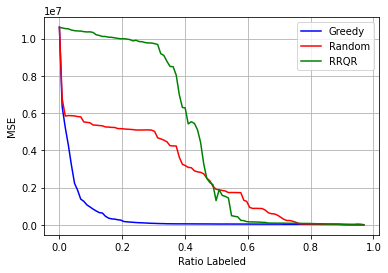

In [257]:
read_tntp_graph("data/Anaheim/Anaheim_flow.tntp")
plt.savefig("Anaheim_results.pdf")
plt.show()

  0%|          | 0/2471 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

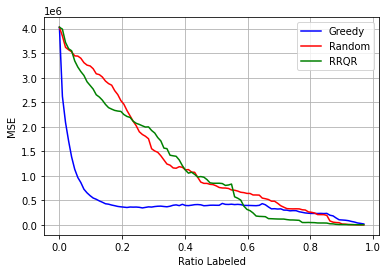

In [259]:
read_tntp_graph("data/Barcelona/Barcelona_flow.tntp")
plt.savefig("Barcelona_results.pdf")
plt.show()

  0%|          | 0/2891 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

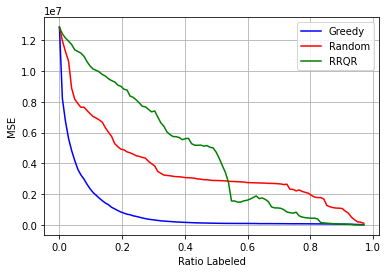

In [260]:
read_tntp_graph("data/Chicago-Sketch/ChicagoSketch_flow.tntp")
plt.savefig("Chicago_results.pdf")
plt.show()

  0%|          | 0/2779 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

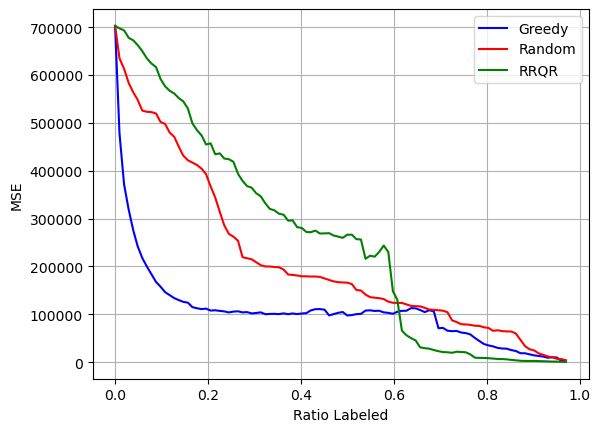

In [298]:
mpl.rcParams.update(mpl.rcParamsDefault)
read_tntp_graph("data/Winnipeg/Winnipeg_flow.tntp")
plt.savefig("Winnipeg_results.png")
plt.savefig("Winnipeg_results.pdf")

plt.show()

## Evaluating the Greedy Algorithm for Levels of Flow Conservation

Something is wrong with these results

In [168]:
def conserved_flow_error(G, epsilon, ratio=0.1):
    G_dummy = deepcopy(G)

    dummy = "dummy"

    for v in deepcopy(G_dummy.nodes()):
        if G_dummy.out_degree(v) == 0:
            G_dummy.add_edge(v, dummy)
        if G_dummy.in_degree(v) == 0:
            G_dummy.add_edge(dummy, v)
    
    # Generate the flows with a dummy node to handle sources/sinks
    flows = synthetic_flows(G_dummy, epsilon=epsilon)

    # Mark all edges to/from the dummy as unlabeled
    for e, f in deepcopy(flows).items():
        if dummy in e:
            del flows[e]
    
    sensors = choose_sensors(G_dummy, flows, flow_prediction, mse, lazy=True, k=int(G.number_of_edges() * ratio))
    return err(G, sensors, flows, int(G.number_of_edges() * ratio))


errs = {}

for i in tqdm(range(20, 110, 10)):
    errs[i] = conserved_flow_error(G, i / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

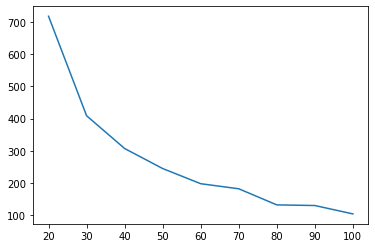

In [170]:
plt.plot(errs.keys(), errs.values())

## Running Sensor Placement Using Only Known Detectors 

In [361]:
with open('data/' + city + '_flows.pkl', 'rb') as f:
    flows = pickle.load(f)

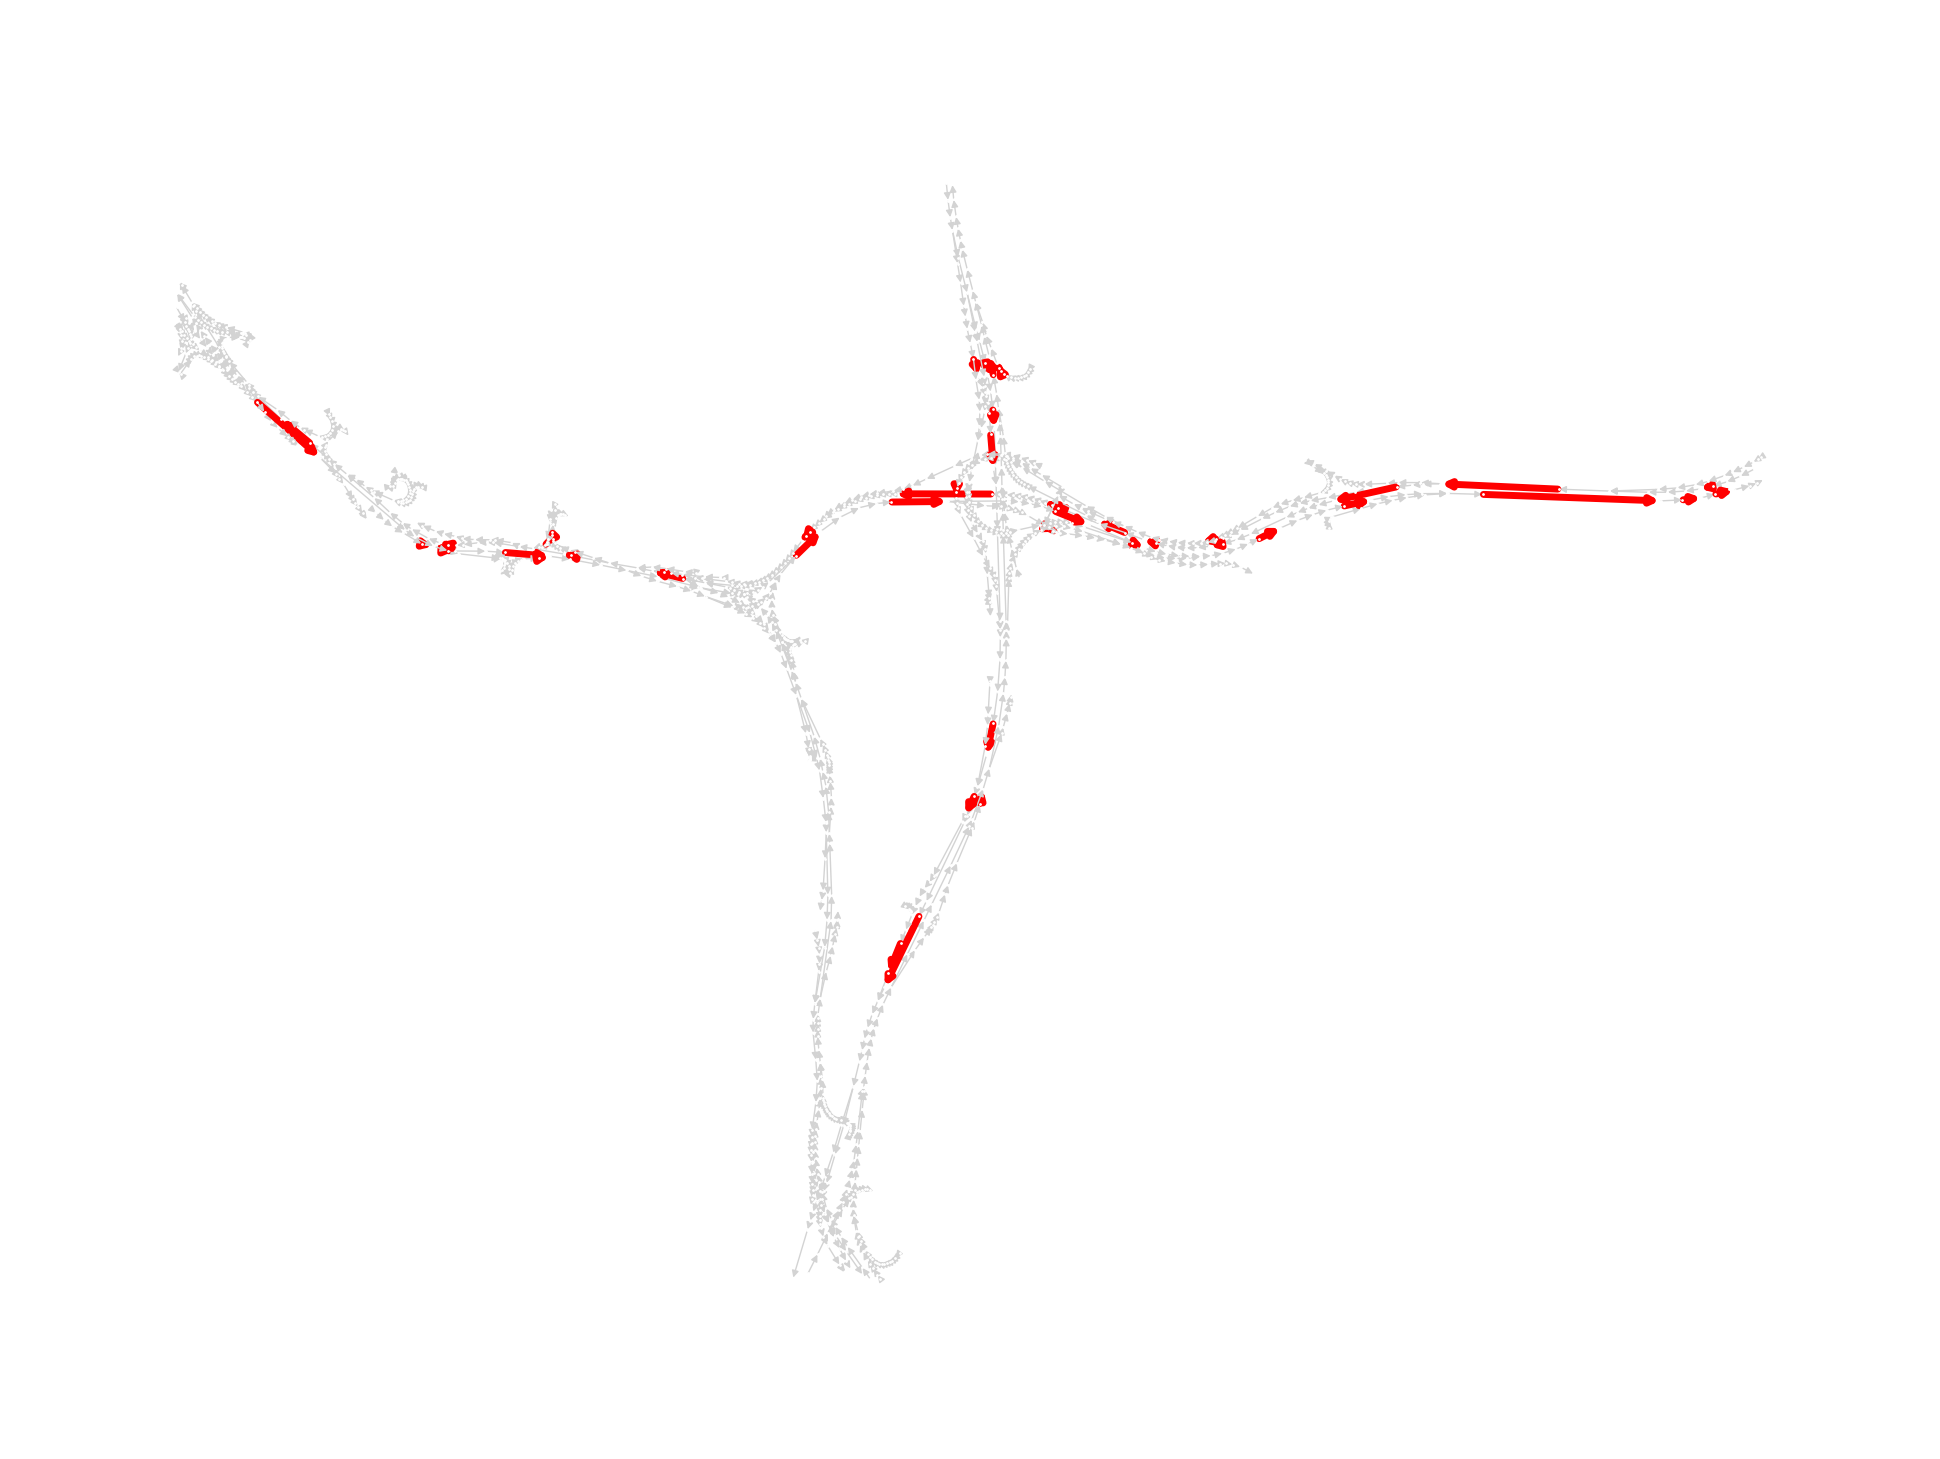

In [362]:
detectors = []

for k, c in flows.items():
    u, v = [int(i) for i in k]
    detectors.append((u,v))

plt.figure(figsize=[3 * 6.4, 3 * 4.8])
edge_color = ["red" if (u, v) in detectors else "lightgray" for u, v in G.edges()]
width = [5 if e in detectors else 1 for e in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_color, width=width)
plt.savefig("original_sensors.pdf")
plt.show()

In [363]:
# Generate the flows with a dummy node to handle sources/sinks
labeled_synthetic_flows = synthetic_flows(G_dummy)

# Mark all edges to/from the dummy as unlabeled
for e, f in deepcopy(labeled_synthetic_flows).items():
    if dummy in e or e not in detectors:
        del labeled_synthetic_flows[e]

In [364]:
len(labeled_synthetic_flows)

43

In [372]:
exp_sensors = choose_sensors(G_dummy, labeled_synthetic_flows, flow_prediction_nls, mse, k=len(detectors))

initial len(deltas): 43


  0%|          | 0/43 [00:00<?, ?it/s]

sensor (1614922742, 1614922738) delta [-457.77596433]
next top sensor (1347515636, 268538952) delta [-3491.18369068]
sensor (1614922742, 1614922738) delta [-457.77596433]
next top sensor (1347515636, 268538952) delta [-3491.18369068]
delta > next, len(deltas): 42
iteration 0 len(deltas): 42
selecting sensor (1614922742, 1614922738) delta [-457.77596433], next sensor (1347515636, 268538952) has delta [-309.10666378]

sensor (1347515636, 268538952) delta [-290.50095458]
next top sensor (1614922903, 69004190) delta [-2985.08274433]
sensor (1347515636, 268538952) delta [-290.50095458]
next top sensor (1614922903, 69004190) delta [-2985.08274433]
delta > next, len(deltas): 41
iteration 1 len(deltas): 41
selecting sensor (1347515636, 268538952) delta [-290.50095458], next sensor (1614922903, 69004190) has delta [-241.65676781]

sensor (1614922903, 69004190) delta [-241.40738476]
next top sensor (363429201, 4055678331) delta [-2666.2186935]
sensor (1614922903, 69004190) delta [-241.40738476]


sensor (1613371763, 1613371771) delta [-17.46655456]
next top sensor (6876014919, 1614922924) delta [-253.20693421]
sensor (1613371763, 1613371771) delta [-17.46655456]
next top sensor (6876014919, 1614922924) delta [-253.20693421]
delta > next, len(deltas): 21
iteration 21 len(deltas): 21
selecting sensor (1613371763, 1613371771) delta [-17.46655456], next sensor (6876014919, 1614922924) has delta [-15.17102523]

sensor (6876014919, 1614922924) delta [-15.92658869]
next top sensor (268539659, 69004190) delta [-234.73206795]
sensor (6876014919, 1614922924) delta [-15.92658869]
next top sensor (268539659, 69004190) delta [-234.73206795]
delta > next, len(deltas): 20
iteration 22 len(deltas): 20
selecting sensor (6876014919, 1614922924) delta [-15.92658869], next sensor (268539762, 20972371) has delta [-9.80695989]

sensor (268539762, 20972371) delta [-5.33714835]
next top sensor (268539659, 69004190) delta [-215.77957162]
sensor (268539762, 20972371) delta [-5.33714835]
next top sensor 

In [374]:
np.random.shuffle(detectors)

errs = {}
random_errs = {}

for i in tqdm(range(samples)):
    j = int(len(random_sensors) / samples) * i
    
    preds = flow_prediction(G_dummy, {s: labeled_synthetic_flows[s] for s in exp_sensors[:j]})
    errs[j] = mse(preds, labeled_synthetic_flows)
    
    random_preds = flow_prediction(G_dummy, {s: labeled_synthetic_flows[s] for s in detectors[:j]})
    random_errs[j] = mse(random_preds, labeled_synthetic_flows)

  0%|          | 0/40 [00:00<?, ?it/s]

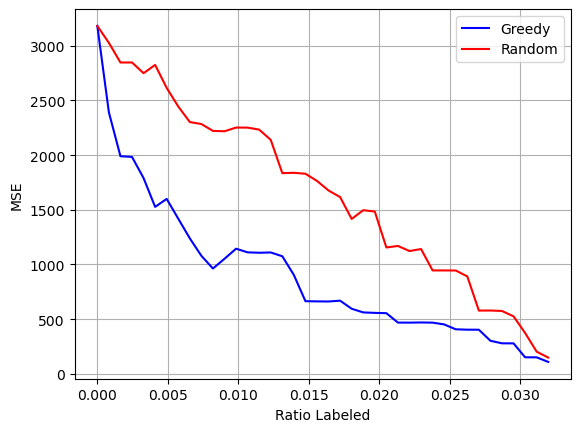

In [375]:
fig, ax = plt.subplots()

ax.plot([k / len(G.edges()) for k in errs.keys()], errs.values(), "b", label="Greedy")
ax.plot([k / len(G.edges()) for k in errs.keys()], random_errs.values(), "r", label="Random")
ax.legend()
plt.xlabel("Ratio Labeled")
plt.ylabel("MSE")
plt.grid("on")
plt.show()